In [1]:
import wandb
import wandb
from wandb.keras import WandbCallback
import os
import cv2
import keras.callbacks
from PIL import Image
import numpy as np
from patchify import patchify
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from matplotlib import pyplot as plt
import random

In [2]:
#Initial wandb
wandb.init(project="sentinel2-segmentation", entity="koltigis")

wandb: Currently logged in as: ugadimas (koltigis). Use `wandb login --relogin` to force relogin


In [3]:
# MinMaxScaler
minmaxscaler = MinMaxScaler()

# Dataset path
dataset_root_folder = 'C:/Users/gis.user/Documents/gisdev2_Dimas/c_learn/a_datascience/b_deep_learning/e_testing/j_planet-segmentation-unet'
dataset_name = 'semantic_segmentation_dataset'

- **for path, subdirs, files in os.walk(os.path.join(dataset_root_folder, dataset_name)):** adalah perulangan **for** yang menggunakan **os.walk** untuk menjelajahi setiap direktori dan file yang ada di dalam **dataset_root_folder/dataset_name**
- **dir_name = path.split(os.path.sep)[-1]** yaitu :
**path.split(os.path.sep)** memecah string path menjadi bagian-bagian berdasarkan separator path. Misalnya, jika path adalah **'folder1/folder2/folder3'**, pemisahan tersebut akan menghasilkan list **['folder1', 'folder2', 'folder3']**
**[-1]** digunakan untuk mengakses elemen terakhir dari list yang dihasilkan. Dalam contoh di atas, ini akan menghasilkan 'folder3'
- **if dir_name == 'masks':**  Pernyataan ini memeriksa apakah direktori saat ini memiliki nama 'masks'
- **images = os.listdir(path):** Baris ini mengambil daftar file yang ada dalam direktori saat ini (path)

In [4]:
for path, subdirs, files in os.walk(os.path.join(dataset_root_folder, dataset_name)):
    dir_name = path.split(os.path.sep)[-1]
    # print(dir_name)
    if dir_name == 'masks':
        images = os.listdir(path)
        print(path)
        # print(images)
        for i, image_name in enumerate(images):
            if (image_name.endswith('.png')):
                # print(image_name)
                a = True

C:/Users/gis.user/Documents/gisdev2_Dimas/c_learn/a_datascience/b_deep_learning/e_testing/j_planet-segmentation-unet\semantic_segmentation_dataset\Tile 1\masks
C:/Users/gis.user/Documents/gisdev2_Dimas/c_learn/a_datascience/b_deep_learning/e_testing/j_planet-segmentation-unet\semantic_segmentation_dataset\Tile 2\masks
C:/Users/gis.user/Documents/gisdev2_Dimas/c_learn/a_datascience/b_deep_learning/e_testing/j_planet-segmentation-unet\semantic_segmentation_dataset\Tile 3\masks
C:/Users/gis.user/Documents/gisdev2_Dimas/c_learn/a_datascience/b_deep_learning/e_testing/j_planet-segmentation-unet\semantic_segmentation_dataset\Tile 4\masks
C:/Users/gis.user/Documents/gisdev2_Dimas/c_learn/a_datascience/b_deep_learning/e_testing/j_planet-segmentation-unet\semantic_segmentation_dataset\Tile 5\masks
C:/Users/gis.user/Documents/gisdev2_Dimas/c_learn/a_datascience/b_deep_learning/e_testing/j_planet-segmentation-unet\semantic_segmentation_dataset\Tile 6\masks
C:/Users/gis.user/Documents/gisdev2_Dima

In [5]:
image_patch_size = 256
image = cv2.imread(f'{dataset_root_folder}/{dataset_name}/Tile 2/images/image_part_001.jpg')
image_patches = patchify(image, (image_patch_size, image_patch_size, 3), step= image_patch_size)
image_x = image_patches[0,0,:,:]
image_y = minmaxscaler.fit_transform(image_x.reshape(-1, image_x.shape[-1])).reshape(image_x.shape)
image_y.shape

(1, 256, 256, 3)

In [6]:
# from PIL import Image

image_dataset = []
mask_dataset = []

for image_type in ['images', 'masks']:
    if image_type == 'images':
        image_extension = 'jpg'
    elif image_type == 'masks':
        image_extension = 'png'
    for tile_id in range(1, 8):
        for image_id in range(1, 20):
            image = cv2.imread(f'{dataset_root_folder}/{dataset_name}/Tile {tile_id}/{image_type}/image_part_00{image_id}.{image_extension}', 1)
            if image is not None:
                if image_type == 'masks':
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                size_x = (image.shape[1] // image_patch_size) * image_patch_size
                size_y = (image.shape[0] // image_patch_size) * image_patch_size
                image = Image.fromarray(image)
                image = image.crop((0, 0, size_x, size_y))
                image = np.array(image)
                patched_images = patchify(image, (image_patch_size, image_patch_size, 3), step=image_patch_size)
                for i in range(patched_images.shape[0]):
                    for j in range(patched_images.shape[1]):  # Perbaikan pada dimensi indeks
                        if image_type == 'images':
                            individual_patched_image = patched_images[i, j, :, :]
                            # print(individual_patched_image.shape)
                            individual_patched_image = minmaxscaler.fit_transform(individual_patched_image.reshape(-1, individual_patched_image.shape[-1])).reshape(individual_patched_image.shape)
                            individual_patched_image = individual_patched_image[0]
                            # print(individual_patched_image.shape)
                            image_dataset.append(individual_patched_image)
                        elif image_type == 'masks':
                            individual_patched_mask = patched_images[i, j, :, :]
                            individual_patched_mask = individual_patched_mask[0]
                            mask_dataset.append(individual_patched_mask)

In [7]:
print(len(image_dataset))
print(len(mask_dataset))

945
945


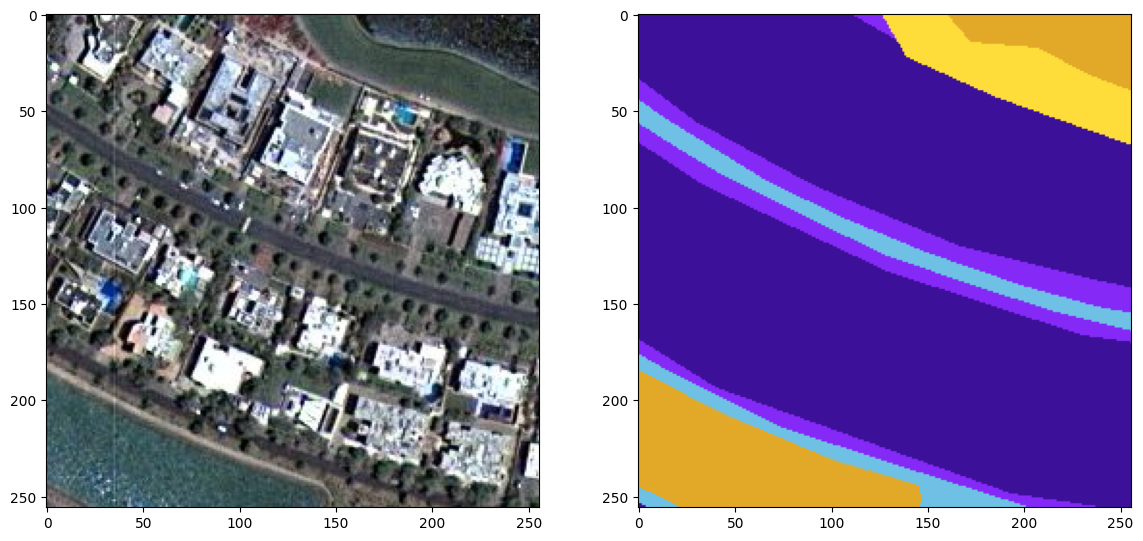

In [9]:
image_dataset = np.array(image_dataset)
mask_dataset = np.array(mask_dataset)
random_image_id = random.randint(0, len(image_dataset))

plt.figure(figsize=(14,8))
plt.subplot(121)
plt.imshow(image_dataset[random_image_id])
plt.subplot(122)
plt.imshow(mask_dataset[random_image_id])

In [10]:
class_building = '#3C1098'
class_building = class_building.lstrip('#')
class_building = np.array(tuple(int(class_building[i:i+2], 16) for i in (0,2,4)))
print(class_building)

class_land = '#8429F6'
class_land = class_land.lstrip('#')
class_land = np.array(tuple(int(class_land[i:i+2], 16) for i in (0,2,4)))
print(class_land)

class_road = '#6EC1E4'
class_road = class_road.lstrip('#')
class_road = np.array(tuple(int(class_road[i:i+2], 16) for i in (0,2,4)))
print(class_road)

class_vegetation = '#FEDD3A'
class_vegetation = class_vegetation.lstrip('#')
class_vegetation = np.array(tuple(int(class_vegetation[i:i+2], 16) for i in (0,2,4)))
print(class_vegetation)

class_water = '#E2A929'
class_water = class_water.lstrip('#')
class_water = np.array(tuple(int(class_water[i:i+2], 16) for i in (0,2,4)))
print(class_water)

class_unlabeled = '#9B9B9B'
class_unlabeled = class_unlabeled.lstrip('#')
class_unlabeled = np.array(tuple(int(class_unlabeled[i:i+2], 16) for i in (0,2,4)))
print(class_unlabeled)

[ 60  16 152]
[132  41 246]
[110 193 228]
[254 221  58]
[226 169  41]
[155 155 155]


In [11]:
label = individual_patched_image
def rgb_to_label(label):
    label_segment = np.zeros(label.shape, dtype=np.uint8)
    label_segment[np.all(label == class_water, axis=-1)] = 0
    label_segment[np.all(label == class_land, axis=-1)] = 1
    label_segment[np.all(label == class_road, axis=-1)] = 2
    label_segment[np.all(label == class_building, axis=-1)] = 3
    label_segment[np.all(label == class_vegetation, axis=-1)] = 4
    label_segment[np.all(label == class_unlabeled, axis=-1)] = 5
    label_segment = label_segment[:,:,0]
    # print(label_segment)
    return label_segment

In [12]:
labels = []
for i in range(mask_dataset.shape[0]):
    label = rgb_to_label(mask_dataset[i])
    labels.append(label)

In [13]:
labels = np.array(labels)
labels[3]

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=uint8)

In [14]:
labels = np.expand_dims(labels, axis=3)

In [15]:
np.unique(labels)

array([0, 1, 2, 3, 4, 5], dtype=uint8)

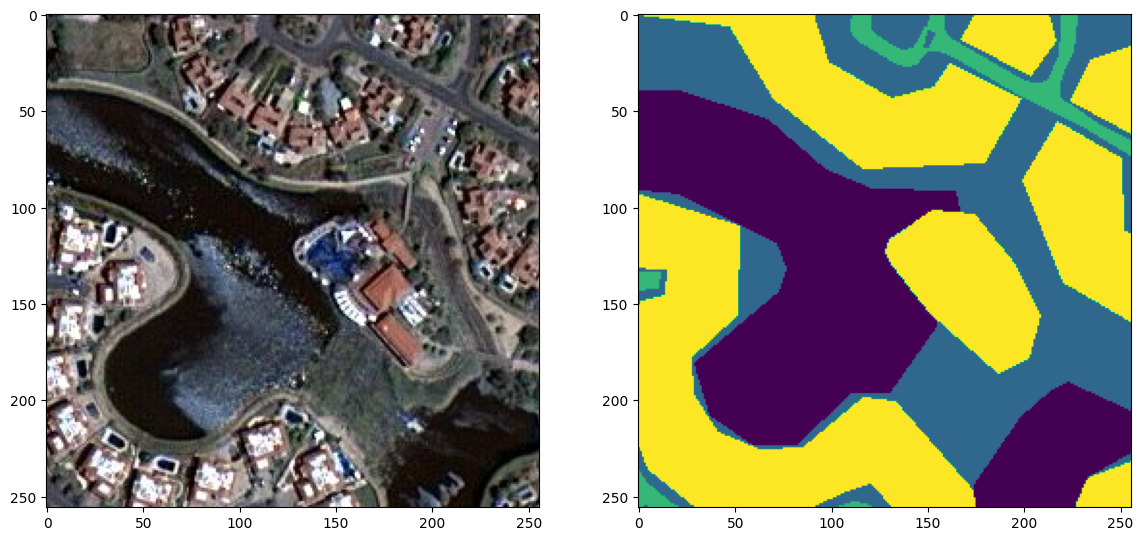

In [16]:
random_image_id = random.randint(0, len(image_dataset))

plt.figure(figsize=(14,8))
plt.subplot(121)
plt.imshow(image_dataset[random_image_id])
plt.subplot(122)
# plt.imshow(mask_dataset[random_image_id])
plt.imshow(labels[random_image_id][:,:,0])

## Split Datasets

In [17]:
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [18]:
total_classes = len(np.unique(labels))
labels_categorical_dataset = to_categorical(labels, num_classes=total_classes)
labels_categorical_dataset.shape

(945, 256, 256, 6)

In [19]:
master_training_dataset = image_dataset
master_training_dataset.shape

(945, 256, 256, 3)

In [20]:
x_train, x_test, y_train, y_test = train_test_split(master_training_dataset, labels_categorical_dataset, test_size=0.15, random_state=100)

In [21]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(803, 256, 256, 3)
(142, 256, 256, 3)
(803, 256, 256, 6)
(142, 256, 256, 6)


**Output :**
(803, 256, 256, 3) => 803 image, ukuran 256 x 256, 3 band
(142, 256, 256, 3)
(803, 256, 256, 6)
(142, 256, 256, 6) => 803 mask, ukuran 256 x 256, 6 kelas

In [22]:
image_height = x_train.shape[1]
image_width = x_train.shape[2]
image_channels = x_train.shape[3]
image_class = y_train.shape[3]

In [23]:
print(f"Image height : {image_height}")
print(f"Image width : {image_width}")
print(f"Image channels : {image_channels}")
print(f"Image class : {image_class}")

Image height : 256
Image width : 256
Image channels : 3
Image class : 6


## Create IoU -> create model architecture -> Fit the model -> generating loss

In [24]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from keras.layers import concatenate, BatchNormalization, Dropout, Lambda

In [25]:
from keras import backend as K

In [27]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [28]:
# Create IoU (Jaccard coefision)
def jaccard_coef(y_true, y_pred):
    y_true_flatten = K.flatten(y_true)
    y_pred_flatten = K.flatten(y_pred)
    intersection = K.sum(y_true_flatten * y_pred_flatten)
    final_coef_value = (intersection + 1.0) / (K.sum(y_true_flatten) + K.sum(y_pred_flatten) - intersection + 1.0)
    return final_coef_value

In [29]:
# Create model architecture
def multi_unet_model(n_class=5, image_height=256, image_width=256, image_channels=1):

    inputs = Input((image_height, image_width, image_channels))

    source_input = inputs

    c1 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(source_input)
    c1 = Dropout(0.2)(c1)
    c1 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c1)
    p1 = MaxPooling2D((2,2))(c1)

    c2 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p1)
    c2 = Dropout(0.2)(c2)
    c2 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c2)
    p2 = MaxPooling2D((2,2))(c2)

    c3 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c3)
    p3 = MaxPooling2D((2,2))(c3)

    c4 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c4)
    p4 = MaxPooling2D((2,2))(c4)

    c5 = Conv2D(256, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p4)
    c5 = Dropout(0.2)(c5)
    c5 = Conv2D(256, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c5)

    u6 = Conv2DTranspose(128, (2,2), strides=(2,2), padding="same")(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c6)

    u7 = Conv2DTranspose(64, (2,2), strides=(2,2), padding="same")(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c7)

    u8 = Conv2DTranspose(32, (2,2), strides=(2,2), padding="same")(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u8)
    c8 = Dropout(0.2)(c8)
    c8 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c8)

    u9 = Conv2DTranspose(16, (2,2), strides=(2,2), padding="same")(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u9)
    c9 = Dropout(0.2)(c9)
    c9 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c9)

    outputs = Conv2D(n_class, (1,1), activation="softmax")(c9)
    model = Model(inputs=[inputs], outputs=[outputs])
    return model

In [30]:
metrics = ["accuracy", jaccard_coef]

In [31]:
def get_deep_learning_model():
    return multi_unet_model(n_class=total_classes,
                            image_height=image_height,
                            image_width=image_width,
                            image_channels=image_channels)

In [32]:
model = get_deep_learning_model()

In [33]:
# Generating loss function
# total_loss = (dice_loss + (1 * focal_loss)
weights = [0.166, 0.166, 0.166, 0.166, 0.166, 0.166]
dice_loss = sm.losses.DiceLoss(class_weights=weights)
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

## Model Compilation

In [34]:
import tensorflow as tf
from IPython.display import clear_output
%matplotlib inline

In [35]:
tf.keras.backend.clear_session()
model.compile(optimizer="adam", loss=total_loss, metrics=metrics)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 256, 256, 16  0           ['conv2d[0][0]']                 
                                )                                                             

In [36]:
class PlotLoss(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.fig = plt.figure()
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1

        clear_output(wait=True)
        plt.plot(self.x, self.losses, label='loss')
        plt.plot(self.x, self.val_losses, label='val_loss')
        plt.legend()
        plt.show();

plot_loss = PlotLoss()

In [37]:
# wandb.log({'accuracy': jaccard_coef, 'loss': total_loss})

In [38]:
# wandb.config.dropout = 0.2

In [39]:
my_callback_object = WandbCallback()
x_train = np.array(x_train)
y_train = np.array(y_train)

model_history = model.fit(x_train, y_train,
                          batch_size=16,
                          verbose=1,
                          epochs=100,
                          validation_data=(x_test, y_test),
                          callbacks=[my_callback_object],
                          shuffle=False)

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/100
51/51 [==============================] - ETA: 0s - loss: 0.9963 - accuracy: 0.5826 - jaccard_coef: 0.2760

INFO:tensorflow:Assets written to: C:\Users\gis.user\Documents\gisdev2_Dimas\c_learn\a_datascience\b_deep_learning\e_testing\j_planet-segmentation-unet\wandb\run-20230619_094719-pd6ur06i\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\gis.user\Documents\gisdev2_Dimas\c_learn\a_datascience\b_deep_learning\e_testing\j_planet-segmentation-unet\wandb\run-20230619_094719-pd6ur06i\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\gis.user\Documents\gisdev2_Dimas\c_learn\a_datascience\b_deep_learning\e_testing\j_planet-segmentation-unet\wandb\run-20230619_094719-pd6ur06i\files\model-best)... Done. 0.1s


51/51 [==============================] - 156s 3s/step - loss: 0.9963 - accuracy: 0.5826 - jaccard_coef: 0.2760 - val_loss: 1.0132 - val_accuracy: 0.4962 - val_jaccard_coef: 0.1717
Epoch 2/100
51/51 [==============================] - ETA: 0s - loss: 0.9783 - accuracy: 0.6771 - jaccard_coef: 0.3752

INFO:tensorflow:Assets written to: C:\Users\gis.user\Documents\gisdev2_Dimas\c_learn\a_datascience\b_deep_learning\e_testing\j_planet-segmentation-unet\wandb\run-20230619_094719-pd6ur06i\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\gis.user\Documents\gisdev2_Dimas\c_learn\a_datascience\b_deep_learning\e_testing\j_planet-segmentation-unet\wandb\run-20230619_094719-pd6ur06i\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\gis.user\Documents\gisdev2_Dimas\c_learn\a_datascience\b_deep_learning\e_testing\j_planet-segmentation-unet\wandb\run-20230619_094719-pd6ur06i\files\model-best)... Done. 0.1s


51/51 [==============================] - 134s 3s/step - loss: 0.9783 - accuracy: 0.6771 - jaccard_coef: 0.3752 - val_loss: 0.9907 - val_accuracy: 0.6053 - val_jaccard_coef: 0.2803
Epoch 3/100
51/51 [==============================] - 137s 3s/step - loss: 0.9681 - accuracy: 0.6924 - jaccard_coef: 0.4118 - val_loss: 0.9937 - val_accuracy: 0.5946 - val_jaccard_coef: 0.2902
Epoch 4/100
51/51 [==============================] - 136s 3s/step - loss: 0.9633 - accuracy: 0.7082 - jaccard_coef: 0.4392 - val_loss: 1.0601 - val_accuracy: 0.4285 - val_jaccard_coef: 0.1969
Epoch 5/100
51/51 [==============================] - 133s 3s/step - loss: 0.9570 - accuracy: 0.7251 - jaccard_coef: 0.4801 - val_loss: 1.0186 - val_accuracy: 0.4989 - val_jaccard_coef: 0.2643
Epoch 6/100
51/51 [==============================] - 133s 3s/step - loss: 0.9515 - accuracy: 0.7437 - jaccard_coef: 0.5034 - val_loss: 0.9992 - val_accuracy: 0.5349 - val_jaccard_coef: 0.2795
Epoch 7/100
51/51 [==============================] -

INFO:tensorflow:Assets written to: C:\Users\gis.user\Documents\gisdev2_Dimas\c_learn\a_datascience\b_deep_learning\e_testing\j_planet-segmentation-unet\wandb\run-20230619_094719-pd6ur06i\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\gis.user\Documents\gisdev2_Dimas\c_learn\a_datascience\b_deep_learning\e_testing\j_planet-segmentation-unet\wandb\run-20230619_094719-pd6ur06i\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\gis.user\Documents\gisdev2_Dimas\c_learn\a_datascience\b_deep_learning\e_testing\j_planet-segmentation-unet\wandb\run-20230619_094719-pd6ur06i\files\model-best)... Done. 0.1s


51/51 [==============================] - 135s 3s/step - loss: 0.9346 - accuracy: 0.7969 - jaccard_coef: 0.5962 - val_loss: 0.9801 - val_accuracy: 0.6648 - val_jaccard_coef: 0.4475
Epoch 13/100
51/51 [==============================] - ETA: 0s - loss: 0.9313 - accuracy: 0.8078 - jaccard_coef: 0.6126

INFO:tensorflow:Assets written to: C:\Users\gis.user\Documents\gisdev2_Dimas\c_learn\a_datascience\b_deep_learning\e_testing\j_planet-segmentation-unet\wandb\run-20230619_094719-pd6ur06i\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\gis.user\Documents\gisdev2_Dimas\c_learn\a_datascience\b_deep_learning\e_testing\j_planet-segmentation-unet\wandb\run-20230619_094719-pd6ur06i\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\gis.user\Documents\gisdev2_Dimas\c_learn\a_datascience\b_deep_learning\e_testing\j_planet-segmentation-unet\wandb\run-20230619_094719-pd6ur06i\files\model-best)... Done. 0.1s


51/51 [==============================] - 135s 3s/step - loss: 0.9313 - accuracy: 0.8078 - jaccard_coef: 0.6126 - val_loss: 0.9649 - val_accuracy: 0.7243 - val_jaccard_coef: 0.5308
Epoch 14/100
51/51 [==============================] - ETA: 0s - loss: 0.9280 - accuracy: 0.8149 - jaccard_coef: 0.6245

INFO:tensorflow:Assets written to: C:\Users\gis.user\Documents\gisdev2_Dimas\c_learn\a_datascience\b_deep_learning\e_testing\j_planet-segmentation-unet\wandb\run-20230619_094719-pd6ur06i\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\gis.user\Documents\gisdev2_Dimas\c_learn\a_datascience\b_deep_learning\e_testing\j_planet-segmentation-unet\wandb\run-20230619_094719-pd6ur06i\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\gis.user\Documents\gisdev2_Dimas\c_learn\a_datascience\b_deep_learning\e_testing\j_planet-segmentation-unet\wandb\run-20230619_094719-pd6ur06i\files\model-best)... Done. 0.1s


51/51 [==============================] - 171s 3s/step - loss: 0.9280 - accuracy: 0.8149 - jaccard_coef: 0.6245 - val_loss: 0.9595 - val_accuracy: 0.7409 - val_jaccard_coef: 0.5453
Epoch 15/100
51/51 [==============================] - ETA: 0s - loss: 0.9279 - accuracy: 0.8151 - jaccard_coef: 0.6241

INFO:tensorflow:Assets written to: C:\Users\gis.user\Documents\gisdev2_Dimas\c_learn\a_datascience\b_deep_learning\e_testing\j_planet-segmentation-unet\wandb\run-20230619_094719-pd6ur06i\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\gis.user\Documents\gisdev2_Dimas\c_learn\a_datascience\b_deep_learning\e_testing\j_planet-segmentation-unet\wandb\run-20230619_094719-pd6ur06i\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\gis.user\Documents\gisdev2_Dimas\c_learn\a_datascience\b_deep_learning\e_testing\j_planet-segmentation-unet\wandb\run-20230619_094719-pd6ur06i\files\model-best)... Done. 0.1s


51/51 [==============================] - 172s 3s/step - loss: 0.9279 - accuracy: 0.8151 - jaccard_coef: 0.6241 - val_loss: 0.9498 - val_accuracy: 0.7496 - val_jaccard_coef: 0.5545
Epoch 16/100
51/51 [==============================] - 178s 3s/step - loss: 0.9262 - accuracy: 0.8202 - jaccard_coef: 0.6330 - val_loss: 0.9716 - val_accuracy: 0.7057 - val_jaccard_coef: 0.5010
Epoch 17/100
51/51 [==============================] - 176s 3s/step - loss: 0.9233 - accuracy: 0.8274 - jaccard_coef: 0.6450 - val_loss: 0.9522 - val_accuracy: 0.7577 - val_jaccard_coef: 0.5670
Epoch 18/100
51/51 [==============================] - ETA: 0s - loss: 0.9208 - accuracy: 0.8340 - jaccard_coef: 0.6556

INFO:tensorflow:Assets written to: C:\Users\gis.user\Documents\gisdev2_Dimas\c_learn\a_datascience\b_deep_learning\e_testing\j_planet-segmentation-unet\wandb\run-20230619_094719-pd6ur06i\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\gis.user\Documents\gisdev2_Dimas\c_learn\a_datascience\b_deep_learning\e_testing\j_planet-segmentation-unet\wandb\run-20230619_094719-pd6ur06i\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\gis.user\Documents\gisdev2_Dimas\c_learn\a_datascience\b_deep_learning\e_testing\j_planet-segmentation-unet\wandb\run-20230619_094719-pd6ur06i\files\model-best)... Done. 0.0s


51/51 [==============================] - 179s 4s/step - loss: 0.9208 - accuracy: 0.8340 - jaccard_coef: 0.6556 - val_loss: 0.9486 - val_accuracy: 0.7701 - val_jaccard_coef: 0.5835
Epoch 19/100
51/51 [==============================] - ETA: 0s - loss: 0.9192 - accuracy: 0.8380 - jaccard_coef: 0.6626

INFO:tensorflow:Assets written to: C:\Users\gis.user\Documents\gisdev2_Dimas\c_learn\a_datascience\b_deep_learning\e_testing\j_planet-segmentation-unet\wandb\run-20230619_094719-pd6ur06i\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\gis.user\Documents\gisdev2_Dimas\c_learn\a_datascience\b_deep_learning\e_testing\j_planet-segmentation-unet\wandb\run-20230619_094719-pd6ur06i\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\gis.user\Documents\gisdev2_Dimas\c_learn\a_datascience\b_deep_learning\e_testing\j_planet-segmentation-unet\wandb\run-20230619_094719-pd6ur06i\files\model-best)... Done. 0.1s


51/51 [==============================] - 227s 4s/step - loss: 0.9192 - accuracy: 0.8380 - jaccard_coef: 0.6626 - val_loss: 0.9442 - val_accuracy: 0.7734 - val_jaccard_coef: 0.5885
Epoch 20/100
51/51 [==============================] - ETA: 0s - loss: 0.9176 - accuracy: 0.8412 - jaccard_coef: 0.6696

INFO:tensorflow:Assets written to: C:\Users\gis.user\Documents\gisdev2_Dimas\c_learn\a_datascience\b_deep_learning\e_testing\j_planet-segmentation-unet\wandb\run-20230619_094719-pd6ur06i\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\gis.user\Documents\gisdev2_Dimas\c_learn\a_datascience\b_deep_learning\e_testing\j_planet-segmentation-unet\wandb\run-20230619_094719-pd6ur06i\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\gis.user\Documents\gisdev2_Dimas\c_learn\a_datascience\b_deep_learning\e_testing\j_planet-segmentation-unet\wandb\run-20230619_094719-pd6ur06i\files\model-best)... Done. 0.0s


51/51 [==============================] - 242s 5s/step - loss: 0.9176 - accuracy: 0.8412 - jaccard_coef: 0.6696 - val_loss: 0.9379 - val_accuracy: 0.7938 - val_jaccard_coef: 0.6108
Epoch 21/100
51/51 [==============================] - 216s 4s/step - loss: 0.9185 - accuracy: 0.8396 - jaccard_coef: 0.6643 - val_loss: 0.9919 - val_accuracy: 0.5355 - val_jaccard_coef: 0.3531
Epoch 22/100
51/51 [==============================] - 207s 4s/step - loss: 0.9176 - accuracy: 0.8428 - jaccard_coef: 0.6718 - val_loss: 0.9566 - val_accuracy: 0.7045 - val_jaccard_coef: 0.4985
Epoch 23/100
51/51 [==============================] - 206s 4s/step - loss: 0.9164 - accuracy: 0.8448 - jaccard_coef: 0.6754 - val_loss: 0.9453 - val_accuracy: 0.7735 - val_jaccard_coef: 0.5856
Epoch 24/100
51/51 [==============================] - ETA: 0s - loss: 0.9162 - accuracy: 0.8454 - jaccard_coef: 0.6752

INFO:tensorflow:Assets written to: C:\Users\gis.user\Documents\gisdev2_Dimas\c_learn\a_datascience\b_deep_learning\e_testing\j_planet-segmentation-unet\wandb\run-20230619_094719-pd6ur06i\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\gis.user\Documents\gisdev2_Dimas\c_learn\a_datascience\b_deep_learning\e_testing\j_planet-segmentation-unet\wandb\run-20230619_094719-pd6ur06i\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\gis.user\Documents\gisdev2_Dimas\c_learn\a_datascience\b_deep_learning\e_testing\j_planet-segmentation-unet\wandb\run-20230619_094719-pd6ur06i\files\model-best)... Done. 0.0s


51/51 [==============================] - 206s 4s/step - loss: 0.9162 - accuracy: 0.8454 - jaccard_coef: 0.6752 - val_loss: 0.9361 - val_accuracy: 0.7953 - val_jaccard_coef: 0.6198
Epoch 25/100
51/51 [==============================] - 212s 4s/step - loss: 0.9133 - accuracy: 0.8525 - jaccard_coef: 0.6883 - val_loss: 0.9424 - val_accuracy: 0.7911 - val_jaccard_coef: 0.6058
Epoch 26/100
51/51 [==============================] - 210s 4s/step - loss: 0.9134 - accuracy: 0.8529 - jaccard_coef: 0.6892 - val_loss: 0.9427 - val_accuracy: 0.7721 - val_jaccard_coef: 0.5514
Epoch 27/100
51/51 [==============================] - 211s 4s/step - loss: 0.9117 - accuracy: 0.8558 - jaccard_coef: 0.6944 - val_loss: 0.9375 - val_accuracy: 0.8021 - val_jaccard_coef: 0.6018
Epoch 28/100
51/51 [==============================] - 213s 4s/step - loss: 0.9140 - accuracy: 0.8490 - jaccard_coef: 0.6822 - val_loss: 0.9502 - val_accuracy: 0.7488 - val_jaccard_coef: 0.4990
Epoch 29/100
51/51 [============================

INFO:tensorflow:Assets written to: C:\Users\gis.user\Documents\gisdev2_Dimas\c_learn\a_datascience\b_deep_learning\e_testing\j_planet-segmentation-unet\wandb\run-20230619_094719-pd6ur06i\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\gis.user\Documents\gisdev2_Dimas\c_learn\a_datascience\b_deep_learning\e_testing\j_planet-segmentation-unet\wandb\run-20230619_094719-pd6ur06i\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\gis.user\Documents\gisdev2_Dimas\c_learn\a_datascience\b_deep_learning\e_testing\j_planet-segmentation-unet\wandb\run-20230619_094719-pd6ur06i\files\model-best)... Done. 0.1s


51/51 [==============================] - 215s 4s/step - loss: 0.9143 - accuracy: 0.8507 - jaccard_coef: 0.6853 - val_loss: 0.9359 - val_accuracy: 0.7958 - val_jaccard_coef: 0.6167
Epoch 30/100
51/51 [==============================] - ETA: 0s - loss: 0.9097 - accuracy: 0.8602 - jaccard_coef: 0.7042

INFO:tensorflow:Assets written to: C:\Users\gis.user\Documents\gisdev2_Dimas\c_learn\a_datascience\b_deep_learning\e_testing\j_planet-segmentation-unet\wandb\run-20230619_094719-pd6ur06i\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\gis.user\Documents\gisdev2_Dimas\c_learn\a_datascience\b_deep_learning\e_testing\j_planet-segmentation-unet\wandb\run-20230619_094719-pd6ur06i\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\gis.user\Documents\gisdev2_Dimas\c_learn\a_datascience\b_deep_learning\e_testing\j_planet-segmentation-unet\wandb\run-20230619_094719-pd6ur06i\files\model-best)... Done. 0.1s


51/51 [==============================] - 225s 4s/step - loss: 0.9097 - accuracy: 0.8602 - jaccard_coef: 0.7042 - val_loss: 0.9302 - val_accuracy: 0.8099 - val_jaccard_coef: 0.6460
Epoch 31/100
51/51 [==============================] - ETA: 0s - loss: 0.9085 - accuracy: 0.8637 - jaccard_coef: 0.7096

INFO:tensorflow:Assets written to: C:\Users\gis.user\Documents\gisdev2_Dimas\c_learn\a_datascience\b_deep_learning\e_testing\j_planet-segmentation-unet\wandb\run-20230619_094719-pd6ur06i\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\gis.user\Documents\gisdev2_Dimas\c_learn\a_datascience\b_deep_learning\e_testing\j_planet-segmentation-unet\wandb\run-20230619_094719-pd6ur06i\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\gis.user\Documents\gisdev2_Dimas\c_learn\a_datascience\b_deep_learning\e_testing\j_planet-segmentation-unet\wandb\run-20230619_094719-pd6ur06i\files\model-best)... Done. 0.1s


51/51 [==============================] - 267s 5s/step - loss: 0.9085 - accuracy: 0.8637 - jaccard_coef: 0.7096 - val_loss: 0.9292 - val_accuracy: 0.8192 - val_jaccard_coef: 0.6467
Epoch 32/100
51/51 [==============================] - 241s 5s/step - loss: 0.9110 - accuracy: 0.8580 - jaccard_coef: 0.7013 - val_loss: 0.9360 - val_accuracy: 0.7980 - val_jaccard_coef: 0.6136
Epoch 33/100
51/51 [==============================] - 246s 5s/step - loss: 0.9093 - accuracy: 0.8612 - jaccard_coef: 0.7074 - val_loss: 0.9437 - val_accuracy: 0.7321 - val_jaccard_coef: 0.5224
Epoch 34/100
51/51 [==============================] - ETA: 0s - loss: 0.9064 - accuracy: 0.8681 - jaccard_coef: 0.7205

INFO:tensorflow:Assets written to: C:\Users\gis.user\Documents\gisdev2_Dimas\c_learn\a_datascience\b_deep_learning\e_testing\j_planet-segmentation-unet\wandb\run-20230619_094719-pd6ur06i\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\gis.user\Documents\gisdev2_Dimas\c_learn\a_datascience\b_deep_learning\e_testing\j_planet-segmentation-unet\wandb\run-20230619_094719-pd6ur06i\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\gis.user\Documents\gisdev2_Dimas\c_learn\a_datascience\b_deep_learning\e_testing\j_planet-segmentation-unet\wandb\run-20230619_094719-pd6ur06i\files\model-best)... Done. 0.0s


51/51 [==============================] - 246s 5s/step - loss: 0.9064 - accuracy: 0.8681 - jaccard_coef: 0.7205 - val_loss: 0.9287 - val_accuracy: 0.8199 - val_jaccard_coef: 0.6475
Epoch 35/100
51/51 [==============================] - 244s 5s/step - loss: 0.9053 - accuracy: 0.8710 - jaccard_coef: 0.7265 - val_loss: 0.9330 - val_accuracy: 0.8060 - val_jaccard_coef: 0.6319
Epoch 36/100
51/51 [==============================] - 242s 5s/step - loss: 0.9051 - accuracy: 0.8714 - jaccard_coef: 0.7282 - val_loss: 0.9311 - val_accuracy: 0.8096 - val_jaccard_coef: 0.6463
Epoch 37/100
51/51 [==============================] - 247s 5s/step - loss: 0.9060 - accuracy: 0.8680 - jaccard_coef: 0.7241 - val_loss: 0.9321 - val_accuracy: 0.8027 - val_jaccard_coef: 0.6309
Epoch 38/100
51/51 [==============================] - 245s 5s/step - loss: 0.9046 - accuracy: 0.8718 - jaccard_coef: 0.7318 - val_loss: 0.9299 - val_accuracy: 0.8044 - val_jaccard_coef: 0.6244
Epoch 39/100
51/51 [============================

INFO:tensorflow:Assets written to: C:\Users\gis.user\Documents\gisdev2_Dimas\c_learn\a_datascience\b_deep_learning\e_testing\j_planet-segmentation-unet\wandb\run-20230619_094719-pd6ur06i\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\gis.user\Documents\gisdev2_Dimas\c_learn\a_datascience\b_deep_learning\e_testing\j_planet-segmentation-unet\wandb\run-20230619_094719-pd6ur06i\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\gis.user\Documents\gisdev2_Dimas\c_learn\a_datascience\b_deep_learning\e_testing\j_planet-segmentation-unet\wandb\run-20230619_094719-pd6ur06i\files\model-best)... Done. 0.1s


51/51 [==============================] - 245s 5s/step - loss: 0.9026 - accuracy: 0.8759 - jaccard_coef: 0.7399 - val_loss: 0.9224 - val_accuracy: 0.8292 - val_jaccard_coef: 0.6828
Epoch 40/100
51/51 [==============================] - 213s 4s/step - loss: 0.9070 - accuracy: 0.8636 - jaccard_coef: 0.7204 - val_loss: 0.9264 - val_accuracy: 0.8197 - val_jaccard_coef: 0.6609
Epoch 41/100
51/51 [==============================] - 213s 4s/step - loss: 0.9031 - accuracy: 0.8746 - jaccard_coef: 0.7374 - val_loss: 0.9314 - val_accuracy: 0.8190 - val_jaccard_coef: 0.6469
Epoch 42/100
51/51 [==============================] - 216s 4s/step - loss: 0.9011 - accuracy: 0.8785 - jaccard_coef: 0.7451 - val_loss: 0.9300 - val_accuracy: 0.8229 - val_jaccard_coef: 0.6790
Epoch 43/100
51/51 [==============================] - ETA: 0s - loss: 0.9006 - accuracy: 0.8792 - jaccard_coef: 0.7466

INFO:tensorflow:Assets written to: C:\Users\gis.user\Documents\gisdev2_Dimas\c_learn\a_datascience\b_deep_learning\e_testing\j_planet-segmentation-unet\wandb\run-20230619_094719-pd6ur06i\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\gis.user\Documents\gisdev2_Dimas\c_learn\a_datascience\b_deep_learning\e_testing\j_planet-segmentation-unet\wandb\run-20230619_094719-pd6ur06i\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\gis.user\Documents\gisdev2_Dimas\c_learn\a_datascience\b_deep_learning\e_testing\j_planet-segmentation-unet\wandb\run-20230619_094719-pd6ur06i\files\model-best)... Done. 0.1s


51/51 [==============================] - 219s 4s/step - loss: 0.9006 - accuracy: 0.8792 - jaccard_coef: 0.7466 - val_loss: 0.9222 - val_accuracy: 0.8283 - val_jaccard_coef: 0.6817
Epoch 44/100
51/51 [==============================] - ETA: 0s - loss: 0.8997 - accuracy: 0.8798 - jaccard_coef: 0.7478

INFO:tensorflow:Assets written to: C:\Users\gis.user\Documents\gisdev2_Dimas\c_learn\a_datascience\b_deep_learning\e_testing\j_planet-segmentation-unet\wandb\run-20230619_094719-pd6ur06i\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\gis.user\Documents\gisdev2_Dimas\c_learn\a_datascience\b_deep_learning\e_testing\j_planet-segmentation-unet\wandb\run-20230619_094719-pd6ur06i\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\gis.user\Documents\gisdev2_Dimas\c_learn\a_datascience\b_deep_learning\e_testing\j_planet-segmentation-unet\wandb\run-20230619_094719-pd6ur06i\files\model-best)... Done. 0.1s


51/51 [==============================] - 234s 5s/step - loss: 0.8997 - accuracy: 0.8798 - jaccard_coef: 0.7478 - val_loss: 0.9190 - val_accuracy: 0.8416 - val_jaccard_coef: 0.7051
Epoch 45/100
51/51 [==============================] - 235s 5s/step - loss: 0.8998 - accuracy: 0.8810 - jaccard_coef: 0.7506 - val_loss: 0.9653 - val_accuracy: 0.6712 - val_jaccard_coef: 0.4889
Epoch 46/100
51/51 [==============================] - 235s 5s/step - loss: 0.9028 - accuracy: 0.8732 - jaccard_coef: 0.7366 - val_loss: 0.9296 - val_accuracy: 0.8182 - val_jaccard_coef: 0.6693
Epoch 47/100
51/51 [==============================] - 234s 5s/step - loss: 0.9005 - accuracy: 0.8778 - jaccard_coef: 0.7442 - val_loss: 0.9228 - val_accuracy: 0.8329 - val_jaccard_coef: 0.6877
Epoch 48/100
51/51 [==============================] - 228s 4s/step - loss: 0.9011 - accuracy: 0.8773 - jaccard_coef: 0.7444 - val_loss: 0.9232 - val_accuracy: 0.8318 - val_jaccard_coef: 0.6837
Epoch 49/100
51/51 [============================

INFO:tensorflow:Assets written to: C:\Users\gis.user\Documents\gisdev2_Dimas\c_learn\a_datascience\b_deep_learning\e_testing\j_planet-segmentation-unet\wandb\run-20230619_094719-pd6ur06i\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\gis.user\Documents\gisdev2_Dimas\c_learn\a_datascience\b_deep_learning\e_testing\j_planet-segmentation-unet\wandb\run-20230619_094719-pd6ur06i\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\gis.user\Documents\gisdev2_Dimas\c_learn\a_datascience\b_deep_learning\e_testing\j_planet-segmentation-unet\wandb\run-20230619_094719-pd6ur06i\files\model-best)... Done. 0.1s


51/51 [==============================] - 236s 5s/step - loss: 0.9001 - accuracy: 0.8748 - jaccard_coef: 0.7393 - val_loss: 0.9174 - val_accuracy: 0.8452 - val_jaccard_coef: 0.7094
Epoch 55/100
51/51 [==============================] - 258s 5s/step - loss: 0.8942 - accuracy: 0.8892 - jaccard_coef: 0.7668 - val_loss: 0.9177 - val_accuracy: 0.8475 - val_jaccard_coef: 0.7098
Epoch 56/100
51/51 [==============================] - 259s 5s/step - loss: 0.8931 - accuracy: 0.8909 - jaccard_coef: 0.7705 - val_loss: 0.9265 - val_accuracy: 0.8236 - val_jaccard_coef: 0.6483
Epoch 57/100
51/51 [==============================] - 258s 5s/step - loss: 0.8946 - accuracy: 0.8882 - jaccard_coef: 0.7652 - val_loss: 0.9228 - val_accuracy: 0.8336 - val_jaccard_coef: 0.6519
Epoch 58/100
51/51 [==============================] - ETA: 0s - loss: 0.8923 - accuracy: 0.8924 - jaccard_coef: 0.7723

INFO:tensorflow:Assets written to: C:\Users\gis.user\Documents\gisdev2_Dimas\c_learn\a_datascience\b_deep_learning\e_testing\j_planet-segmentation-unet\wandb\run-20230619_094719-pd6ur06i\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\gis.user\Documents\gisdev2_Dimas\c_learn\a_datascience\b_deep_learning\e_testing\j_planet-segmentation-unet\wandb\run-20230619_094719-pd6ur06i\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\gis.user\Documents\gisdev2_Dimas\c_learn\a_datascience\b_deep_learning\e_testing\j_planet-segmentation-unet\wandb\run-20230619_094719-pd6ur06i\files\model-best)... Done. 0.0s


51/51 [==============================] - 263s 5s/step - loss: 0.8923 - accuracy: 0.8924 - jaccard_coef: 0.7723 - val_loss: 0.9156 - val_accuracy: 0.8510 - val_jaccard_coef: 0.7031
Epoch 59/100
51/51 [==============================] - 225s 4s/step - loss: 0.8922 - accuracy: 0.8949 - jaccard_coef: 0.7771 - val_loss: 0.9167 - val_accuracy: 0.8535 - val_jaccard_coef: 0.7198
Epoch 60/100
51/51 [==============================] - ETA: 0s - loss: 0.8930 - accuracy: 0.8889 - jaccard_coef: 0.7660

INFO:tensorflow:Assets written to: C:\Users\gis.user\Documents\gisdev2_Dimas\c_learn\a_datascience\b_deep_learning\e_testing\j_planet-segmentation-unet\wandb\run-20230619_094719-pd6ur06i\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\gis.user\Documents\gisdev2_Dimas\c_learn\a_datascience\b_deep_learning\e_testing\j_planet-segmentation-unet\wandb\run-20230619_094719-pd6ur06i\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\gis.user\Documents\gisdev2_Dimas\c_learn\a_datascience\b_deep_learning\e_testing\j_planet-segmentation-unet\wandb\run-20230619_094719-pd6ur06i\files\model-best)... Done. 0.1s


51/51 [==============================] - 229s 4s/step - loss: 0.8930 - accuracy: 0.8889 - jaccard_coef: 0.7660 - val_loss: 0.9142 - val_accuracy: 0.8530 - val_jaccard_coef: 0.7101
Epoch 61/100
51/51 [==============================] - ETA: 0s - loss: 0.8915 - accuracy: 0.8943 - jaccard_coef: 0.7766

INFO:tensorflow:Assets written to: C:\Users\gis.user\Documents\gisdev2_Dimas\c_learn\a_datascience\b_deep_learning\e_testing\j_planet-segmentation-unet\wandb\run-20230619_094719-pd6ur06i\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\gis.user\Documents\gisdev2_Dimas\c_learn\a_datascience\b_deep_learning\e_testing\j_planet-segmentation-unet\wandb\run-20230619_094719-pd6ur06i\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\gis.user\Documents\gisdev2_Dimas\c_learn\a_datascience\b_deep_learning\e_testing\j_planet-segmentation-unet\wandb\run-20230619_094719-pd6ur06i\files\model-best)... Done. 0.0s


51/51 [==============================] - 205s 4s/step - loss: 0.8915 - accuracy: 0.8943 - jaccard_coef: 0.7766 - val_loss: 0.9117 - val_accuracy: 0.8593 - val_jaccard_coef: 0.7310
Epoch 62/100
51/51 [==============================] - 240s 5s/step - loss: 0.8901 - accuracy: 0.8970 - jaccard_coef: 0.7810 - val_loss: 0.9135 - val_accuracy: 0.8543 - val_jaccard_coef: 0.7107
Epoch 63/100
51/51 [==============================] - 240s 5s/step - loss: 0.8881 - accuracy: 0.9010 - jaccard_coef: 0.7892 - val_loss: 0.9178 - val_accuracy: 0.8521 - val_jaccard_coef: 0.7037
Epoch 64/100
51/51 [==============================] - 235s 5s/step - loss: 0.8884 - accuracy: 0.9010 - jaccard_coef: 0.7883 - val_loss: 0.9145 - val_accuracy: 0.8582 - val_jaccard_coef: 0.7233
Epoch 65/100
51/51 [==============================] - 237s 5s/step - loss: 0.8868 - accuracy: 0.9023 - jaccard_coef: 0.7906 - val_loss: 0.9163 - val_accuracy: 0.8572 - val_jaccard_coef: 0.6990
Epoch 66/100
51/51 [============================

INFO:tensorflow:Assets written to: C:\Users\gis.user\Documents\gisdev2_Dimas\c_learn\a_datascience\b_deep_learning\e_testing\j_planet-segmentation-unet\wandb\run-20230619_094719-pd6ur06i\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\gis.user\Documents\gisdev2_Dimas\c_learn\a_datascience\b_deep_learning\e_testing\j_planet-segmentation-unet\wandb\run-20230619_094719-pd6ur06i\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\gis.user\Documents\gisdev2_Dimas\c_learn\a_datascience\b_deep_learning\e_testing\j_planet-segmentation-unet\wandb\run-20230619_094719-pd6ur06i\files\model-best)... Done. 0.0s


51/51 [==============================] - 226s 4s/step - loss: 0.8933 - accuracy: 0.8825 - jaccard_coef: 0.7539 - val_loss: 0.9116 - val_accuracy: 0.8600 - val_jaccard_coef: 0.7302
Epoch 85/100
51/51 [==============================] - 204s 4s/step - loss: 0.8822 - accuracy: 0.9090 - jaccard_coef: 0.8046 - val_loss: 0.9119 - val_accuracy: 0.8570 - val_jaccard_coef: 0.7184
Epoch 86/100
51/51 [==============================] - ETA: 0s - loss: 0.8794 - accuracy: 0.9140 - jaccard_coef: 0.8151

INFO:tensorflow:Assets written to: C:\Users\gis.user\Documents\gisdev2_Dimas\c_learn\a_datascience\b_deep_learning\e_testing\j_planet-segmentation-unet\wandb\run-20230619_094719-pd6ur06i\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\gis.user\Documents\gisdev2_Dimas\c_learn\a_datascience\b_deep_learning\e_testing\j_planet-segmentation-unet\wandb\run-20230619_094719-pd6ur06i\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\gis.user\Documents\gisdev2_Dimas\c_learn\a_datascience\b_deep_learning\e_testing\j_planet-segmentation-unet\wandb\run-20230619_094719-pd6ur06i\files\model-best)... Done. 0.0s


51/51 [==============================] - 210s 4s/step - loss: 0.8794 - accuracy: 0.9140 - jaccard_coef: 0.8151 - val_loss: 0.9100 - val_accuracy: 0.8663 - val_jaccard_coef: 0.7457
Epoch 87/100
51/51 [==============================] - 217s 4s/step - loss: 0.8791 - accuracy: 0.9145 - jaccard_coef: 0.8162 - val_loss: 0.9139 - val_accuracy: 0.8571 - val_jaccard_coef: 0.7316
Epoch 88/100
51/51 [==============================] - 213s 4s/step - loss: 0.8781 - accuracy: 0.9165 - jaccard_coef: 0.8194 - val_loss: 0.9139 - val_accuracy: 0.8615 - val_jaccard_coef: 0.7281
Epoch 89/100
51/51 [==============================] - 217s 4s/step - loss: 0.8794 - accuracy: 0.9134 - jaccard_coef: 0.8149 - val_loss: 0.9129 - val_accuracy: 0.8605 - val_jaccard_coef: 0.7241
Epoch 90/100
51/51 [==============================] - 219s 4s/step - loss: 0.8775 - accuracy: 0.9165 - jaccard_coef: 0.8202 - val_loss: 0.9113 - val_accuracy: 0.8641 - val_jaccard_coef: 0.7382
Epoch 91/100
51/51 [============================

In [60]:
history_a = model_history

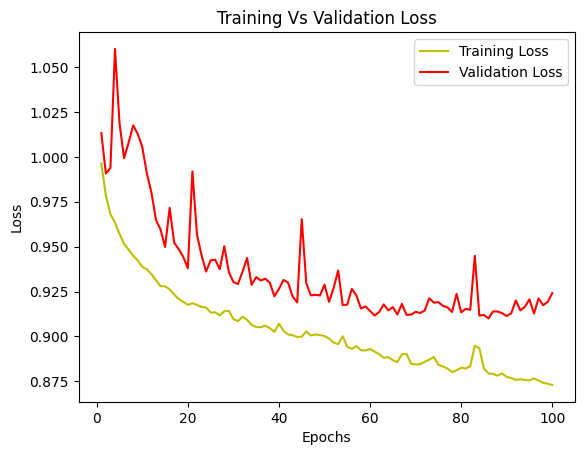

In [61]:
loss = history_a.history['loss']
val_loss = history_a.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label="Training Loss")
plt.plot(epochs, val_loss, 'r', label="Validation Loss")
plt.title("Training Vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

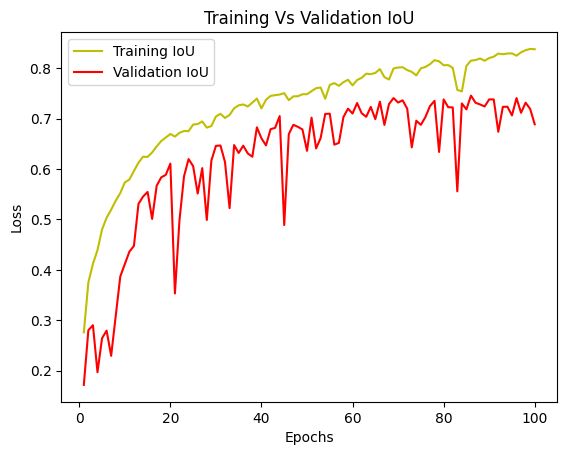

In [62]:
jaccard_coef = history_a.history['jaccard_coef']
val_jaccard_coef = history_a.history['val_jaccard_coef']

epochs = range(1, len(jaccard_coef) + 1)
plt.plot(epochs, jaccard_coef, 'y', label="Training IoU")
plt.plot(epochs, val_jaccard_coef, 'r', label="Validation IoU")
plt.title("Training Vs Validation IoU")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [63]:
model_history.params

{'verbose': 1, 'epochs': 100, 'steps': 51}

In [64]:
y_pred = model.predict(x_test)

5/5 [==============================] - 7s 1s/step


In [65]:
len(y_pred)

142

In [66]:
y_pred

array([[[[1.10649047e-02, 8.73493969e-01, 6.99724406e-02,
          3.55654396e-02, 9.57419630e-03, 3.29078641e-04],
         [2.52617849e-03, 9.05900836e-01, 5.39121367e-02,
          3.17727961e-02, 5.83863864e-03, 4.93863154e-05],
         [1.35913992e-03, 8.52281511e-01, 7.14165643e-02,
          6.61701784e-02, 8.68429244e-03, 8.83855682e-05],
         ...,
         [2.05224101e-03, 8.06322694e-01, 5.64188063e-02,
          1.24024250e-01, 1.09914243e-02, 1.90583101e-04],
         [4.91662649e-03, 7.63002396e-01, 7.82701150e-02,
          1.29875243e-01, 2.35664621e-02, 3.69113026e-04],
         [2.07257029e-02, 6.35805428e-01, 1.39916152e-01,
          1.37936711e-01, 6.17584102e-02, 3.85755021e-03]],

        [[1.74178497e-03, 9.14089143e-01, 5.72371222e-02,
          2.29327399e-02, 3.96044087e-03, 3.87620748e-05],
         [2.19549125e-04, 9.41117108e-01, 3.74001674e-02,
          1.93002913e-02, 1.95907359e-03, 3.83728047e-06],
         [7.16929790e-05, 9.41118419e-01, 3.2691

In [67]:
y_pred_argmax = np.argmax(y_pred, axis=3)

In [68]:
len(y_pred_argmax)

142

In [69]:
y_pred_argmax

array([[[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[2, 2, 2, ..., 1, 1, 1],
        [2, 2, 2, ..., 1, 1, 1],
        [2, 2, 2, ..., 1, 1, 1],
        ...,
        [2, 2, 2, ..., 2, 1, 1],
        [2, 2, 2, ..., 2, 2, 1],
        [2, 2, 2, ..., 2, 2, 2]],

       ...,

       [[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 4, 4, 4],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 4, 1, 4]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

In [70]:
y_test_argmax = np.argmax(y_test, axis=3)

In [71]:
y_test_argmax

array([[[3, 3, 3, ..., 1, 1, 1],
        [3, 3, 3, ..., 3, 3, 3],
        [3, 3, 3, ..., 3, 3, 3],
        ...,
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[2, 2, 2, ..., 1, 1, 1],
        [2, 2, 2, ..., 1, 1, 1],
        [2, 2, 2, ..., 1, 1, 1],
        ...,
        [2, 2, 2, ..., 0, 0, 0],
        [2, 2, 2, ..., 0, 0, 0],
        [2, 2, 1, ..., 0, 0, 0]],

       ...,

       [[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

## Perbandingan antara mask ground truth dan mask predicted

In [72]:
import random

In [73]:
test_image_number = random.randint(0, len(x_test))

test_image = x_test[test_image_number]
ground_truth_image = y_test_argmax[test_image_number]

test_image_input = np.expand_dims(test_image, 0)

prediction = model.predict(test_image_input)
predicted_image = np.argmax(prediction, axis=3)
predicted_image = predicted_image[0,:,:]

1/1 [==============================] - 0s 90ms/step


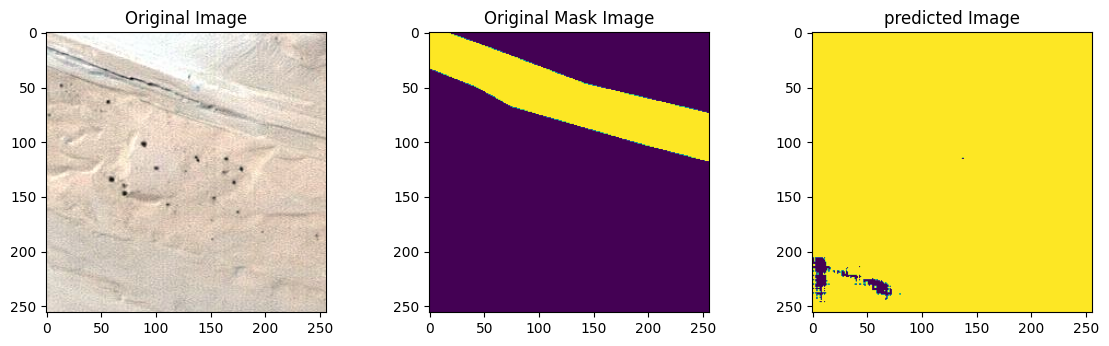

In [74]:
plt.figure(figsize=(14,8))

plt.subplot(231)
plt.title("Original Image")
plt.imshow(test_image)

plt.subplot(232)
plt.title("Original Mask Image")
plt.imshow(ground_truth_image)

plt.subplot(233)
plt.title("predicted Image")
plt.imshow(predicted_image)

## Save dan reload model dengan memodifikasi loss

In [57]:
model.save("satellite_segmentation_100_epoch.h5")

In [58]:
from keras.models import load_model

In [76]:
#load model
saved_model = load_model(
    'C:/Users/gis.user/Documents/gisdev2_Dimas/c_learn/a_datascience/b_deep_learning/e_testing/j_planet-segmentation-unet/satellite_segmentation_100_epoch.h5',
    custom_objects=({'dice_loss_plus_1focal_loss' : total_loss, 'jaccard_coef': jaccard_coef})
)

In [77]:
#perform model
test_image_number = random.randint(0, len(x_test))
test_image = x_test[test_image_number]
ground_truth_image = y_test_argmax[test_image_number]
test_image_input = np.expand_dims(test_image, 0)
prediction = saved_model.predict(test_image_input)
predicted_image = np.argmax(prediction, axis=3)
predicted_image = predicted_image[0,:,:]

1/1 [==============================] - 0s 202ms/step


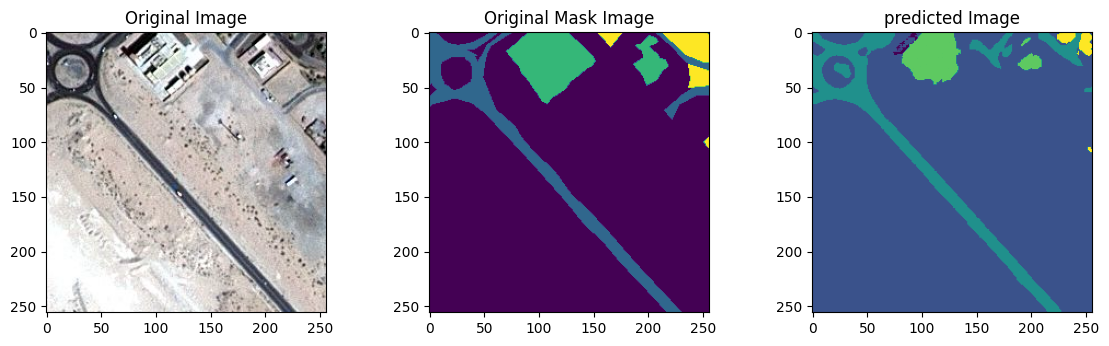

In [78]:
plt.figure(figsize=(14,8))

plt.subplot(231)
plt.title("Original Image")
plt.imshow(test_image)

plt.subplot(232)
plt.title("Original Mask Image")
plt.imshow(ground_truth_image)

plt.subplot(233)
plt.title("predicted Image")
plt.imshow(predicted_image)

## F. Implementasi model ke data baru

(256, 256, 3)


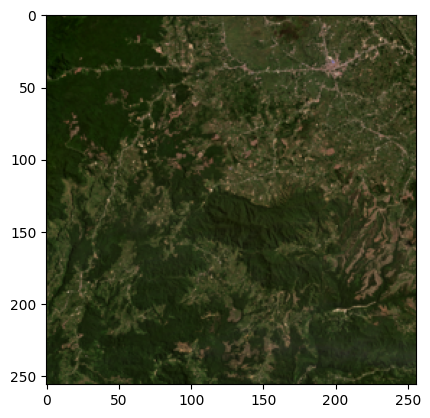

In [86]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Membaca gambar
image = Image.open('C:/Users/gis.user/Documents/gisdev2_Dimas/c_learn/a_datascience/b_deep_learning/e_testing/j_planet-segmentation-unet/sentinel2_imagery.tif')

# Mereshape gambar ke (None, 256, 256, 3)
image = image.resize((256, 256))
image = np.array(image)
image_rgb = image[:, :, :3]

# Cek bentuk hasil reshape
print(image_rgb.shape)

# # Menyimpan citra dalam format JPEG
# output_path = 'C:/Users/gis.user/Documents/gisdev2_Dimas/c_learn/a_datascience/b_deep_learning/e_testing/j_planet-segmentation-unet/sentinel2_imagery.jpg'
# image_jpg = Image.fromarray(image_rgb)
# image_jpg.save(output_path)

# Menampilkan citra
plt.imshow(image_rgb)
plt.show()


In [87]:
image = np.expand_dims(image_rgb, 0)

In [88]:
prediction_sentinel = saved_model.predict(image)

1/1 [==============================] - 0s 79ms/step


In [89]:
predicted_image_sentinel = np.argmax(prediction_sentinel, axis=3)
predicted_image_sentinel = predicted_image_sentinel[0,:,:]

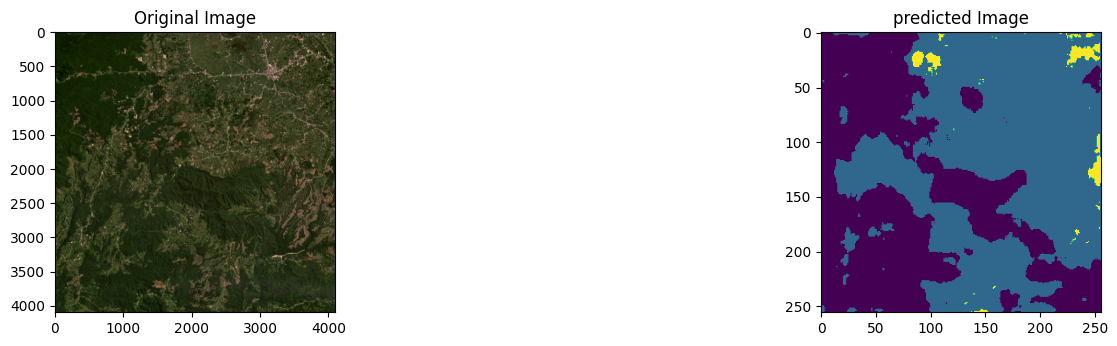

In [90]:
plt.figure(figsize=(14,8))

plt.subplot(231)
plt.title("Original Image")
plt.imshow(Image.open('C:/Users/gis.user/Documents/gisdev2_Dimas/c_learn/a_datascience/b_deep_learning/e_testing/j_planet-segmentation-unet/sentinel2_imagery.tif'))

plt.subplot(233)
plt.title("predicted Image")
plt.imshow(predicted_image_sentinel)

## Membuat activation dan heatmap

In [71]:
import keract as ke

In [72]:
activations = ke.get_activations(saved_model, image, nodes_to_evaluate=None, output_format='simple', auto_compile=True)

In [74]:
ke.display_activations(activations,
                       cmap='viridis',
                       save=True,
                       directory='C:/Users/dimas.perceka/OneDrive - Koltiva/Desktop/Belajar/Deep Learning/Rob_cole/j_planet-segmentation-unet/j_planet-segmentation-unet/activations')

input_1 (1, 256, 256, 3) 
conv2d (1, 256, 256, 16) 
dropout (1, 256, 256, 16) 
conv2d_1 (1, 256, 256, 16) 
max_pooling2d (1, 128, 128, 16) 
conv2d_2 (1, 128, 128, 32) 
dropout_1 (1, 128, 128, 32) 
conv2d_3 (1, 128, 128, 32) 
max_pooling2d_1 (1, 64, 64, 32) 
conv2d_4 (1, 64, 64, 64) 
dropout_2 (1, 64, 64, 64) 
conv2d_5 (1, 64, 64, 64) 
max_pooling2d_2 (1, 32, 32, 64) 
conv2d_6 (1, 32, 32, 128) 
dropout_3 (1, 32, 32, 128) 
conv2d_7 (1, 32, 32, 128) 
max_pooling2d_3 (1, 16, 16, 128) 
conv2d_8 (1, 16, 16, 256) 
dropout_4 (1, 16, 16, 256) 
conv2d_9 (1, 16, 16, 256) 
conv2d_transpose (1, 32, 32, 128) 
concatenate (1, 32, 32, 256) 
conv2d_10 (1, 32, 32, 128) 
dropout_5 (1, 32, 32, 128) 
conv2d_11 (1, 32, 32, 128) 
conv2d_transpose_1 (1, 64, 64, 64) 
concatenate_1 (1, 64, 64, 128) 
conv2d_12 (1, 64, 64, 64) 
dropout_6 (1, 64, 64, 64) 
conv2d_13 (1, 64, 64, 64) 
conv2d_transpose_2 (1, 128, 128, 32) 
concatenate_2 (1, 128, 128, 64) 
conv2d_14 (1, 128, 128, 32) 
dropout_7 (1, 128, 128, 32) 
conv2

In [76]:
# Membaca gambar
image = Image.open('C:/Users/dimas.perceka/OneDrive - Koltiva/Desktop/Belajar/Deep Learning/Rob_cole/j_planet-segmentation-unet/j_planet-segmentation-unet/sentinel2_imagery.tif')

# Mereshape gambar ke (None, 256, 256, 3)
image = image.resize((256, 256))
image = np.array(image)
image_rgb = image[:, :, :3]
image_rgb = image_rgb.astype(np.float32)
ke.display_heatmaps(activations, image_rgb, save=True, directory='C:/Users/dimas.perceka/OneDrive - Koltiva/Desktop/Belajar/Deep Learning/Rob_cole/j_planet-segmentation-unet/j_planet-segmentation-unet/heatmap')

input_1 (1, 256, 256, 3) 
conv2d (1, 256, 256, 16) 
dropout (1, 256, 256, 16) 
conv2d_1 (1, 256, 256, 16) 
max_pooling2d (1, 128, 128, 16) 
conv2d_2 (1, 128, 128, 32) 
dropout_1 (1, 128, 128, 32) 
conv2d_3 (1, 128, 128, 32) 
max_pooling2d_1 (1, 64, 64, 32) 
conv2d_4 (1, 64, 64, 64) 
dropout_2 (1, 64, 64, 64) 
conv2d_5 (1, 64, 64, 64) 
max_pooling2d_2 (1, 32, 32, 64) 
conv2d_6 (1, 32, 32, 128) 
dropout_3 (1, 32, 32, 128) 
conv2d_7 (1, 32, 32, 128) 
max_pooling2d_3 (1, 16, 16, 128) 
conv2d_8 (1, 16, 16, 256) 
dropout_4 (1, 16, 16, 256) 
conv2d_9 (1, 16, 16, 256) 
conv2d_transpose (1, 32, 32, 128) 
concatenate (1, 32, 32, 256) 
conv2d_10 (1, 32, 32, 128) 
dropout_5 (1, 32, 32, 128) 
conv2d_11 (1, 32, 32, 128) 
conv2d_transpose_1 (1, 64, 64, 64) 
concatenate_1 (1, 64, 64, 128) 
conv2d_12 (1, 64, 64, 64) 
dropout_6 (1, 64, 64, 64) 
conv2d_13 (1, 64, 64, 64) 
conv2d_transpose_2 (1, 128, 128, 32) 
concatenate_2 (1, 128, 128, 64) 
conv2d_14 (1, 128, 128, 32) 
dropout_7 (1, 128, 128, 32) 
conv2

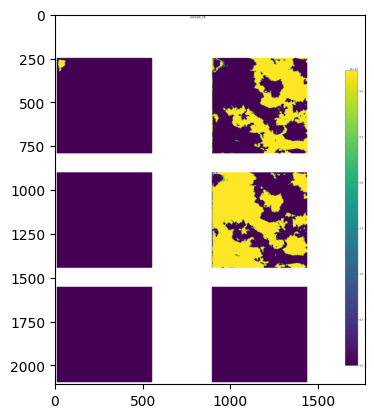

In [77]:
plt.imshow(Image.open('C:/Users/dimas.perceka/OneDrive - Koltiva/Desktop/Belajar/Deep Learning/Rob_cole/j_planet-segmentation-unet/j_planet-segmentation-unet/activations/40_conv2d_18.png'))

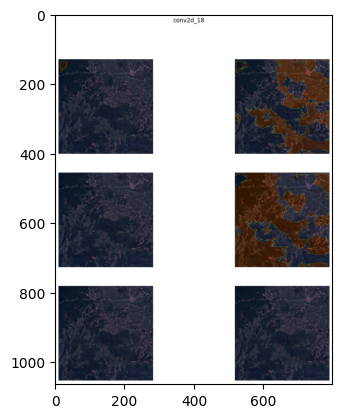

In [78]:
plt.imshow(Image.open('C:/Users/dimas.perceka/OneDrive - Koltiva/Desktop/Belajar/Deep Learning/Rob_cole/j_planet-segmentation-unet/j_planet-segmentation-unet/heatmap/40_conv2d_18.png'))